# Credit Risk Modeling & Scorecard Using XGBoost

Utilizing XGBoost to predict credit risk (default probability) for loans, leveraging XGBoost `interation_constraints` to improve explanability of the trees, and explore scorecard value for each independent variable based on its feature importance plot and tree plot. 

Dataset source: [Kaggle]('https://www.kaggle.com/datasets/sneharshinde/ltfs-av-data?select=train.csv')

Notebook is inspired by GTC 2021 Building Credit Risk Scorecards [Demo]('https://github.com/rapidsai-community/showcase/tree/main/event_notebooks/GTC_2021/credit_scorecard/cpu')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/CreditRisk_AF')
!pwd

import sys
sys.path.append('/content/drive/MyDrive/CreditRisk_AF')

/content/drive/MyDrive/CreditRisk_AF


## Load data and libraries

In [4]:
# import personal files
from clean_data import *

# import ML libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier, plot_tree, plot_importance

import time


In [5]:
def model_auc_score (modelname, x_set, y_set):
    y_prob = modelname.predict_proba(x_set)[:, 1]
    fprs, lprs, thresholds = roc_curve(y_set, y_prob)
    model_auc_score = roc_auc_score(y_set, y_prob)
    return model_auc_score, fprs, lprs, thresholds

def model_auc_plot(result, modelname):
    plt.plot(result[1], result[2], color = 'cornflowerblue',
            lw=1, label = f'AUC_{modelname} = %0.6f' % result[0])
    plt.plot([0, 1], [0, 1], color = 'navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc="best")

In [6]:
# load data
df_loan = pd.read_csv("train.csv")

# check columns and observations in the dataset
df_loan.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [7]:
# check data column information including null and unique values
summary_df = summarytable(df_loan)
summary_df

Dataset Shape: (233154, 41)


,Name,dtypes,Missing,Missing_Percentage,Uniques,Uniques_Percentage,First Value,Second Value,Third Value,Last Value
0,UniqueID,int64,0,0.00,233154,1.00,420825,537409,417566,630213
1,disbursed_amount,int64,0,0.00,24565,0.11,50578,47145,53278,75751
2,asset_cost,int64,0,0.00,46252,0.20,58400,65550,61360,116009
3,ltv,float64,0,0.00,6579,0.03,89.55,73.23,89.63,66.81
4,branch_id,int64,0,0.00,82,0.00,67,67,67,77
5,supplier_id,int64,0,0.00,2953,0.01,22807,22807,22807,22186
6,manufacturer_id,int64,0,0.00,11,0.00,45,45,45,86
7,Current_pincode_ID,int64,0,0.00,6698,0.03,1441,1502,1497,2299
8,Date.of.Birth,object,0,0.00,15433,0.07,01-01-84,31-07-85,24-08-85,18-02-84
9,Employment.Type,object,7661,0.03,2,0.00,Salaried,Self employed,Self employed,Salaried


## Data cleaning, preprocessing and EDA

In [8]:
## Specify special columns in the dataset that are identification or target variables
## You can have multiple id_vars, hence it is required to be a list
id_var = ['UniqueID']
targ_var = 'loan_default'

# Perform some feature engineering and dataset clean-up
# rename columns, convert data types, handling outliers and missing values, convert time strings to numeric integers
df_loan_clean = af_data_clean(df_loan, id_var, targ_var)
df_loan_clean.sample(10, random_state=0).sort_index()

,UniqueID,loan_default,disbursed_amount,asset_cost,ltv,manufacturer_id,Employment_Type,State_ID,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS_SCORE,PERFORM_CNS_SCORE_DESCRIPTION,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_AMOUNT,PRI_DISBURSED_AMOUNT,SEC_NO_OF_ACCTS,SEC_ACTIVE_ACCTS,SEC_OVERDUE_ACCTS,SEC_CURRENT_BALANCE,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,NO_OF_INQUIRIES,AgeInYear,DaysSinceDisbursement,AcctAgeInMonths,CreditHistLenInMonths
36826,454954,0,50903,69149,75.20,86,Salaried,4,1,0,0,0,0,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,NaN,0,0,0,0,43.0,132.0,0,0
53030,471430,0,57822,69420,85.00,86,Salaried,8,1,0,0,0,0,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,NaN,0,0,0,0,53.0,125.0,0,0
89937,508984,0,62447,81500,78.53,86,Salaried,4,1,1,0,0,0,597.0,I-Medium Risk,1.0,1.0,0.0,0.0,190000.0,190000.0,0,0,0,0,0,0,0.0,0,0,0,0,32.0,108.0,28,28
96740,515897,0,49803,66089,77.17,86,Self employed,6,1,0,0,0,0,NaN,Not Scored: No Updates available in last 36 mo...,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,39.0,105.0,34,34
133959,553618,1,61613,78000,80.00,120,Self employed,4,1,0,0,0,0,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,NaN,0,0,0,0,44.0,93.0,0,0
148894,568733,0,56259,67500,84.44,86,Self employed,9,0,0,1,0,0,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,NaN,0,0,0,0,39.0,82.0,0,0
156462,576398,0,50303,65240,79.71,51,Self employed,1,1,0,0,0,0,818.0,A-Very Low Risk,2.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,900.0,0,0,0,0,36.0,80.0,6,6
164491,584480,0,48682,67295,74.45,51,Self employed,1,1,0,0,0,0,762.0,B-Very Low Risk,1.0,1.0,0.0,0.0,40000.0,40000.0,0,0,0,0,0,0,2639.0,0,0,0,1,47.0,76.0,22,22
202730,623317,0,49053,61310,82.37,45,Self employed,4,0,0,1,0,0,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,NaN,0,0,0,0,40.0,67.0,0,0
210916,631654,0,43794,70211,63.24,49,Self employed,3,1,0,0,0,0,551.0,J-High Risk,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0,0,1,0,31.0,66.0,8,8


In [9]:
df_loan_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 36 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UniqueID                             233154 non-null  int64  
 1   loan_default                         233154 non-null  int64  
 2   disbursed_amount                     233154 non-null  int64  
 3   asset_cost                           233154 non-null  int64  
 4   ltv                                  233154 non-null  float64
 5   manufacturer_id                      233154 non-null  object 
 6   Employment_Type                      225493 non-null  object 
 7   State_ID                             233154 non-null  object 
 8   Aadhar_flag                          233154 non-null  object 
 9   PAN_flag                             233154 non-null  object 
 10  VoterID_flag                         233154 non-null  object 
 11  Driving_flag 

In [10]:
# creat list of categorical variables and numeric variables

non_p_vars = id_var + [targ_var]
p_vars = df_loan_clean.columns.drop(non_p_vars).tolist()
num_p_vars = sorted(df_loan_clean[p_vars]._get_numeric_data().columns)
cat_p_vars = sorted(set(df_loan_clean[p_vars].columns) - set(num_p_vars))
len(p_vars), len(num_p_vars), len(cat_p_vars)

(34, 25, 9)

In [11]:
cat_p_vars

['Aadhar_flag',
 'Driving_flag',
 'Employment_Type',
 'PAN_flag',
 'PERFORM_CNS_SCORE_DESCRIPTION',
 'Passport_flag',
 'State_ID',
 'VoterID_flag',
 'manufacturer_id']

In [12]:
num_p_vars

['AcctAgeInMonths',
 'AgeInYear',
 'CreditHistLenInMonths',
 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS',
 'DaysSinceDisbursement',
 'NEW_ACCTS_IN_LAST_SIX_MONTHS',
 'NO_OF_INQUIRIES',
 'PERFORM_CNS_SCORE',
 'PRIMARY_INSTAL_AMT',
 'PRI_ACTIVE_ACCTS',
 'PRI_CURRENT_BALANCE',
 'PRI_DISBURSED_AMOUNT',
 'PRI_NO_OF_ACCTS',
 'PRI_OVERDUE_ACCTS',
 'PRI_SANCTIONED_AMOUNT',
 'SEC_ACTIVE_ACCTS',
 'SEC_CURRENT_BALANCE',
 'SEC_DISBURSED_AMOUNT',
 'SEC_INSTAL_AMT',
 'SEC_NO_OF_ACCTS',
 'SEC_OVERDUE_ACCTS',
 'SEC_SANCTIONED_AMOUNT',
 'asset_cost',
 'disbursed_amount',
 'ltv']

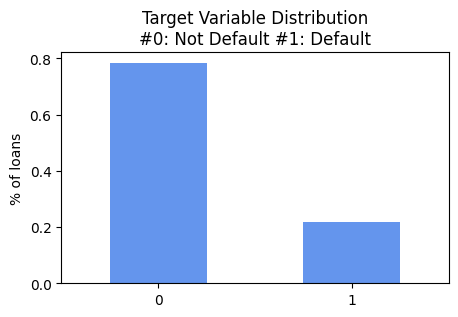

In [12]:
# understand the target variable distribution

plt.figure(figsize=(5, 3))
df_loan_clean['loan_default'].value_counts(normalize=True).plot(kind='bar', color='cornflowerblue')
plt.ylabel('% of loans')
plt.title('Target Variable Distribution\n#0: Not Default #1: Default')
plt.xticks(rotation=360)
plt.show()

### EDA: numeric variables

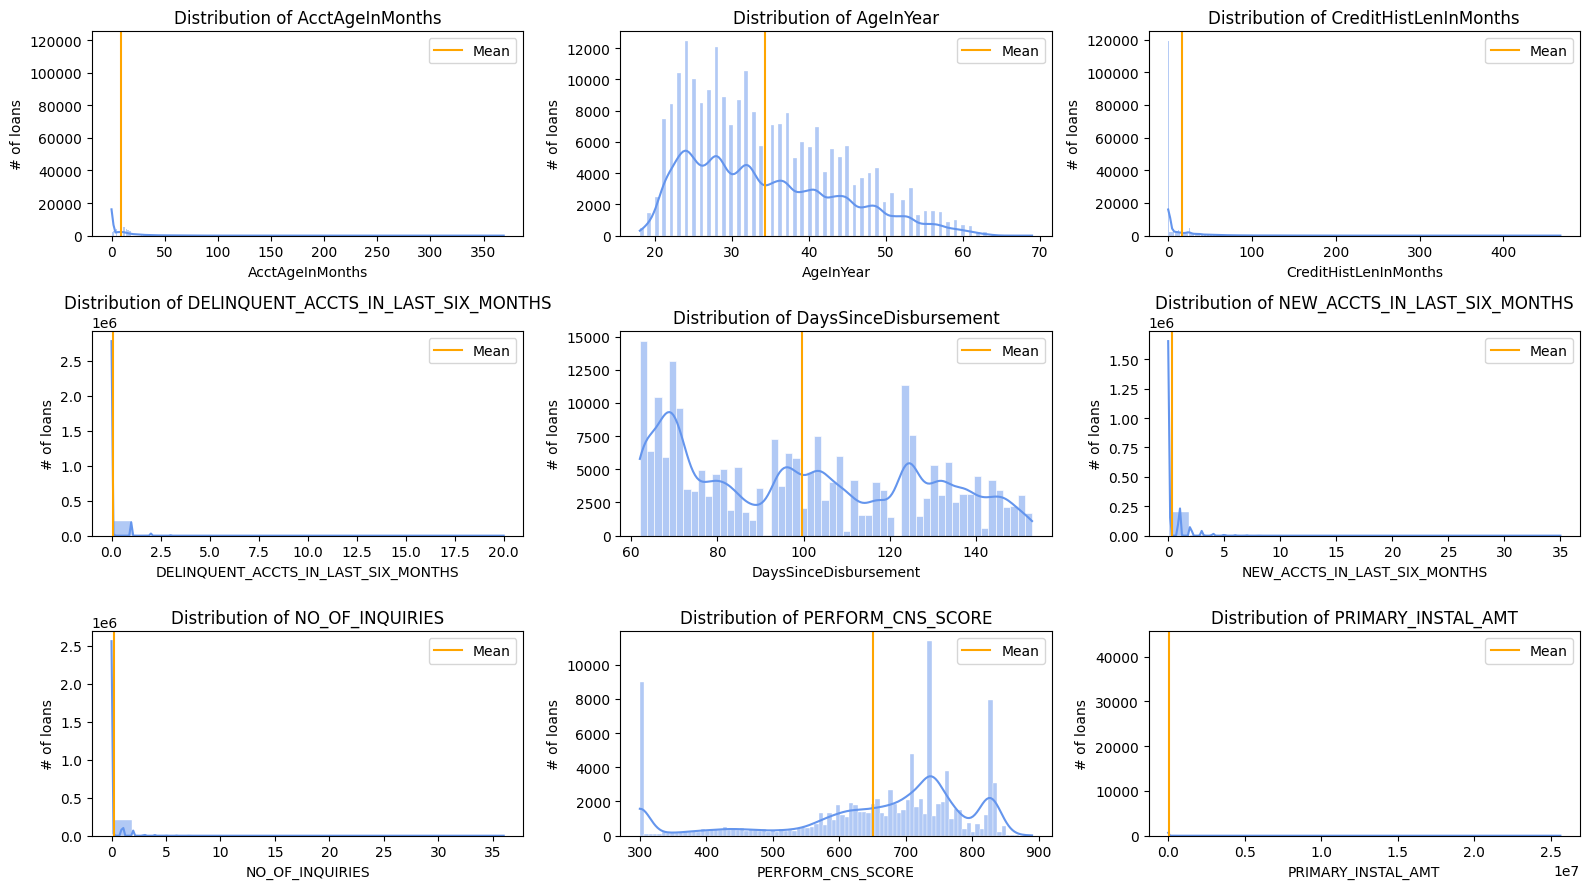

In [ ]:
# plot distribution for key numeric variables
plt.subplots(3,3,figsize=(16,9))

for i, column in enumerate(num_p_vars[:9], 1):
    plt.subplot(3,3,i)
    hist_plot(df_loan_clean, column)

plt.tight_layout()
plt.show()

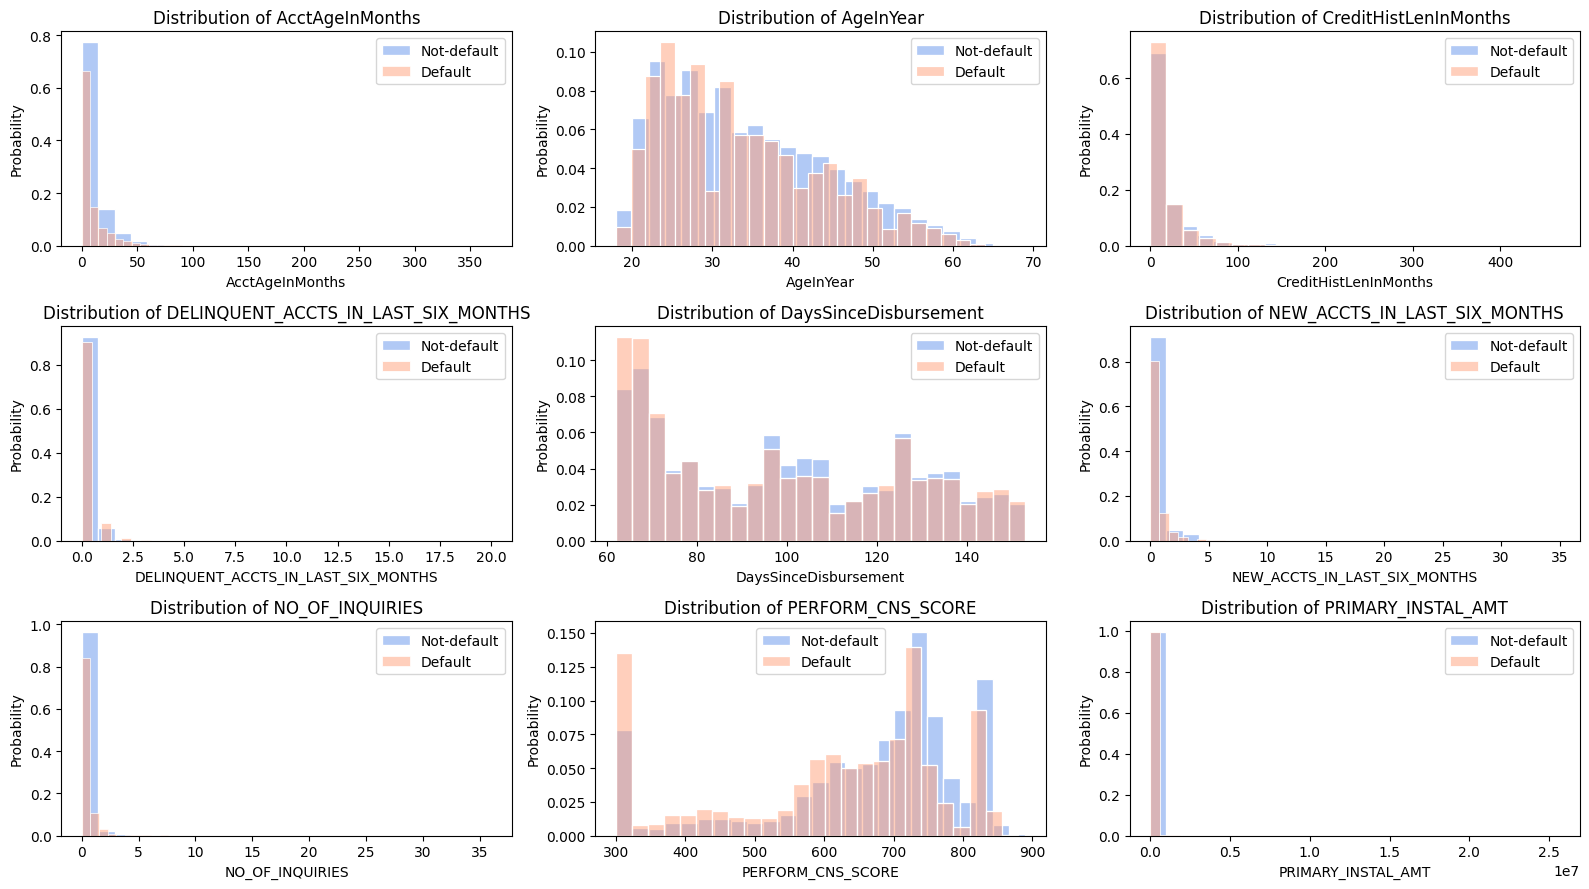

In [ ]:
# plot distribution for key numeric variables across two classes

plt.subplots(3,3,figsize=(16,9))

for i, column in enumerate(num_p_vars[:9], 1):
    plt.subplot(3,3,i)
    histcompare_plot(df_loan_clean, column, targ_var)

plt.tight_layout()
plt.show()

Note: it shows that relatively lower `PERFORM_CNS_SCORE` with relatively higher probability of loan default based on the distribution.

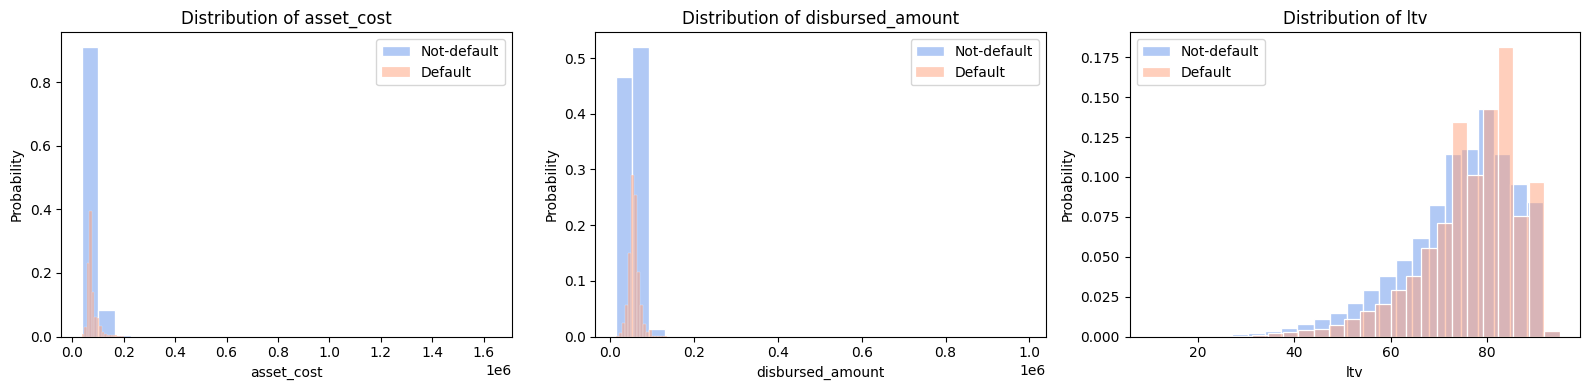

In [ ]:
# plot the distribution for 'asset_cost',  'disbursed_amount', and 'ltv'

plt.subplots(1,3,figsize=(16,4))

for i, column in enumerate(num_p_vars[-3:], 1):
    plt.subplot(1,3,i)
    histcompare_plot(df_loan_clean, column, targ_var)

plt.tight_layout()
plt.show()

### EDA: categorical variables

In [13]:
# further look into CNS score and its description

df_CNS = df_loan_clean.groupby('PERFORM_CNS_SCORE_DESCRIPTION').agg({'PERFORM_CNS_SCORE': ['min', 'mean', 'max']})
df_CNS

PERFORM_CNS_SCORE  \
                                                                 min   
PERFORM_CNS_SCORE_DESCRIPTION                                          
                                                                 NaN   
A-Very Low Risk                                                806.0   
B-Very Low Risk                                                761.0   
C-Very Low Risk                                                736.0   
D-Very Low Risk                                                706.0   
E-Low Risk                                                     681.0   
F-Low Risk                                                     651.0   
G-Low Risk                                                     631.0   
H-Medium Risk                                                  601.0   
I-Medium Risk                                                  571.0   
J-High Risk                                                    521.0   
K-High Risk                                                    351.0   
L-Very High Risk                                               301.0   
M-Very High Risk                                               300.0   
Not Scored: More than 50 active Accounts found                   NaN   
Not Scored: No Activity seen on the customer (I...               NaN   
Not Scored: No Updates available in last 36 months               NaN   
Not Scored: Not Enough Info available on the cu...               NaN   
Not Scored: Only a Guarantor                                     NaN   
Not Scored: Sufficient History Not Available                     NaN   

                                                                       
                                                          mean    max  
PERFORM_CNS_SCORE_DESCRIPTION                                          
                                                           NaN    NaN  
A-Very Low Risk                                     827.662631  890.0  
B-Very Low Risk                                     774.183893  805.0  
C-Very Low Risk                                     741.899221  760.0  
D-Very Low Risk                                     715.958091  735.0  
E-Low Risk                                          691.517437  705.0  
F-Low Risk                                          666.064467  680.0  
G-Low Risk                                          640.853561  650.0  
H-Medium Risk                                       617.031947  630.0  
I-Medium Risk                                       586.832644  600.0  
J-High Risk                                         549.876734  570.0  
K-High Risk                                         440.594177  520.0  
L-Very High Risk                                    326.601411  350.0  
M-Very High Risk                                    300.000000  300.0  
Not Scored: More than 50 active Accounts found             NaN    NaN  
Not Scored: No Activity seen on the customer (I...         NaN    NaN  
Not Scored: No Updates available in last 36 months         NaN    NaN  
Not Scored: Not Enough Info available on the cu...         NaN    NaN  
Not Scored: Only a Guarantor                               NaN    NaN  
Not Scored: Sufficient History Not Available               NaN    NaN

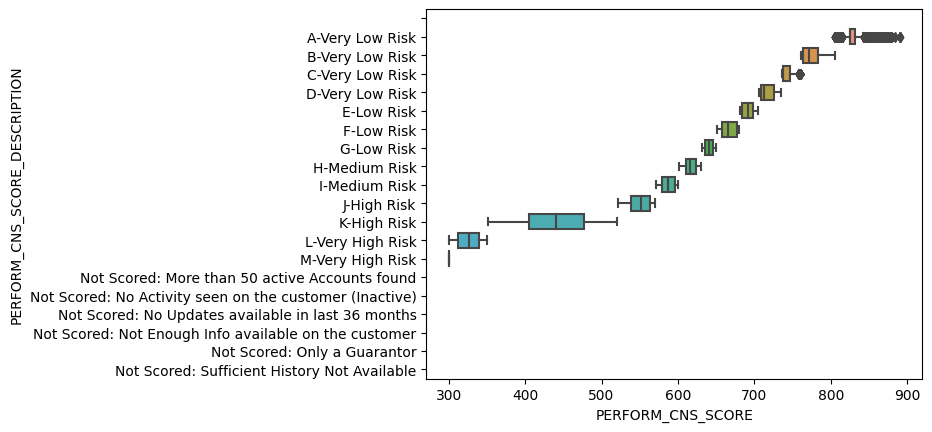

In [ ]:
# plotting the chart for better comparison

fig, ax = plt.subplots()
sns.boxplot(x=df_loan_clean['PERFORM_CNS_SCORE'], y=df_loan_clean['PERFORM_CNS_SCORE_DESCRIPTION'], data=df_loan_clean, order = df_CNS.index)
# ax.set_xlim(250, 900)
plt.show()

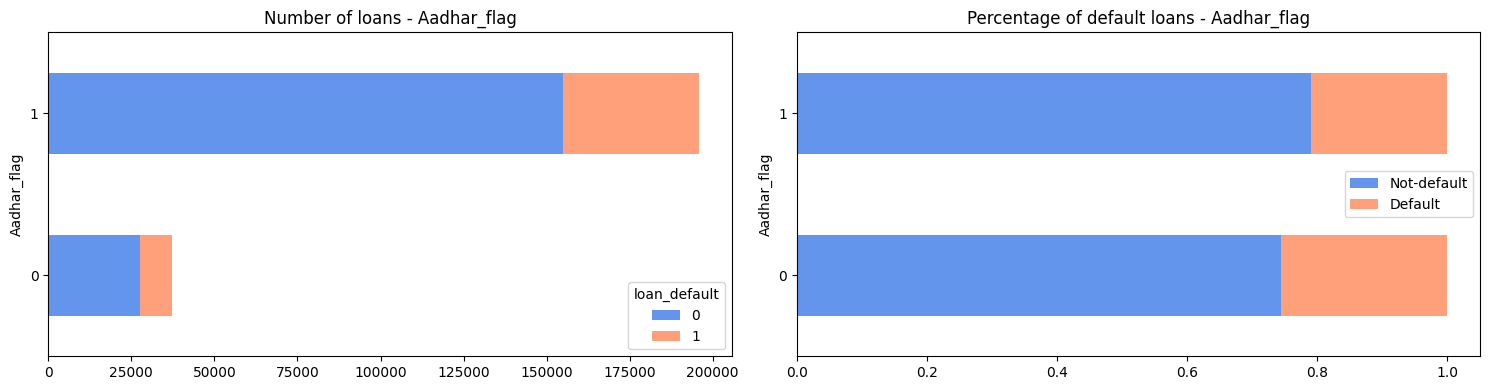

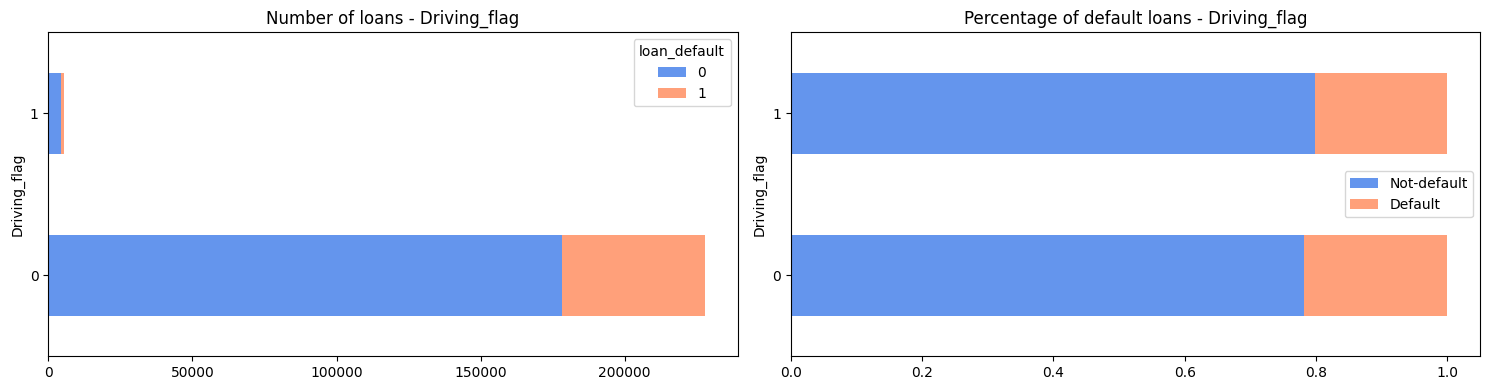

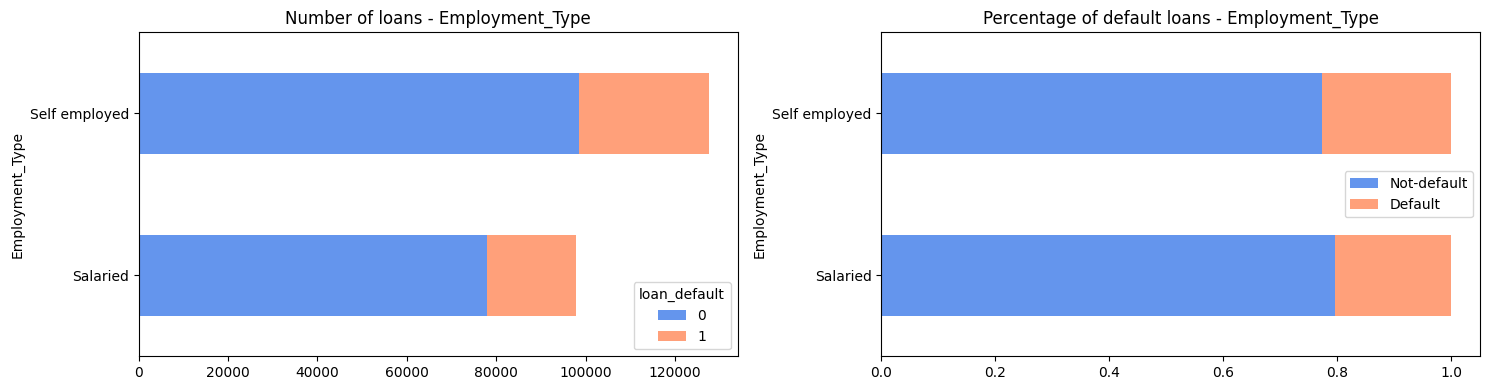

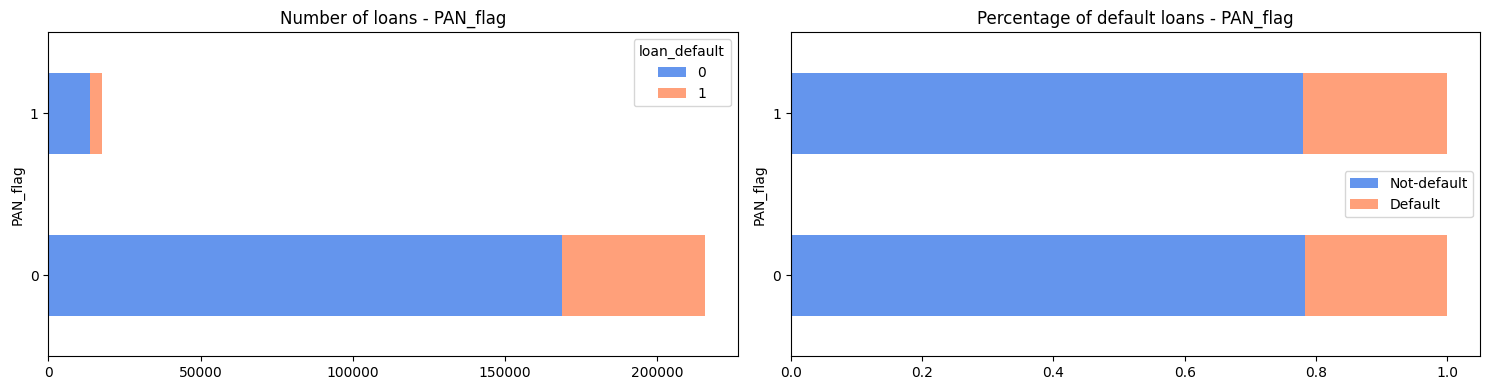

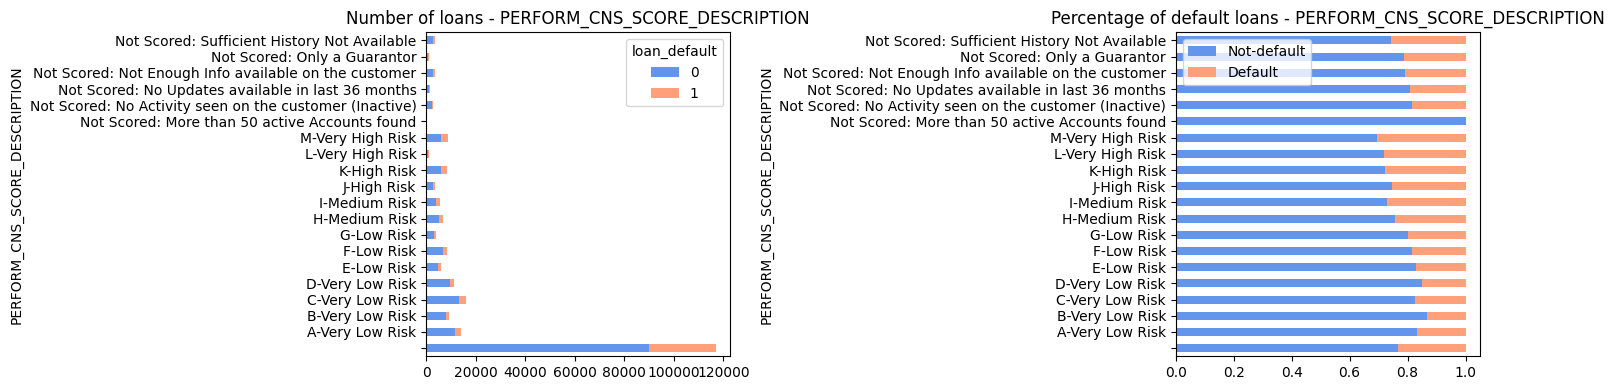

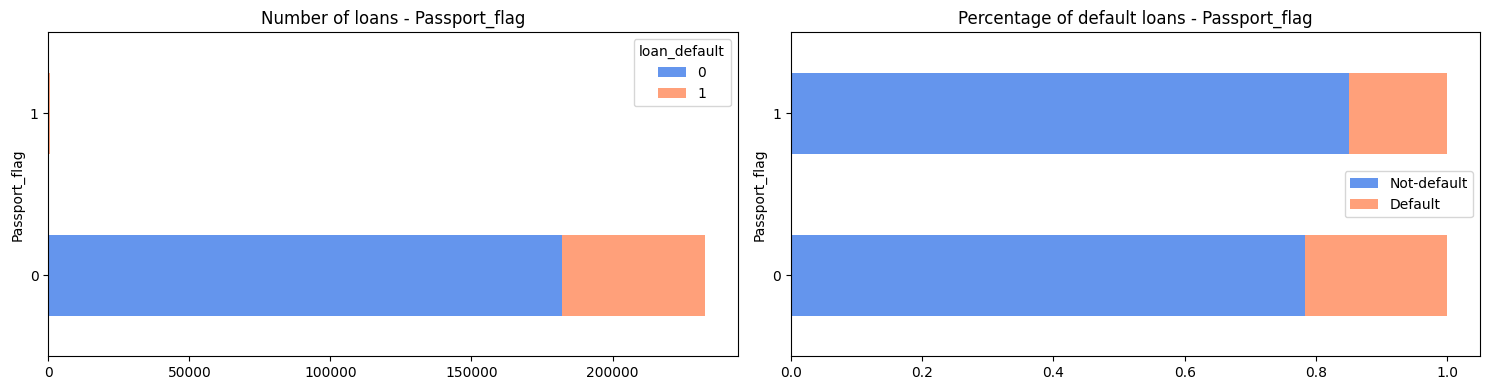

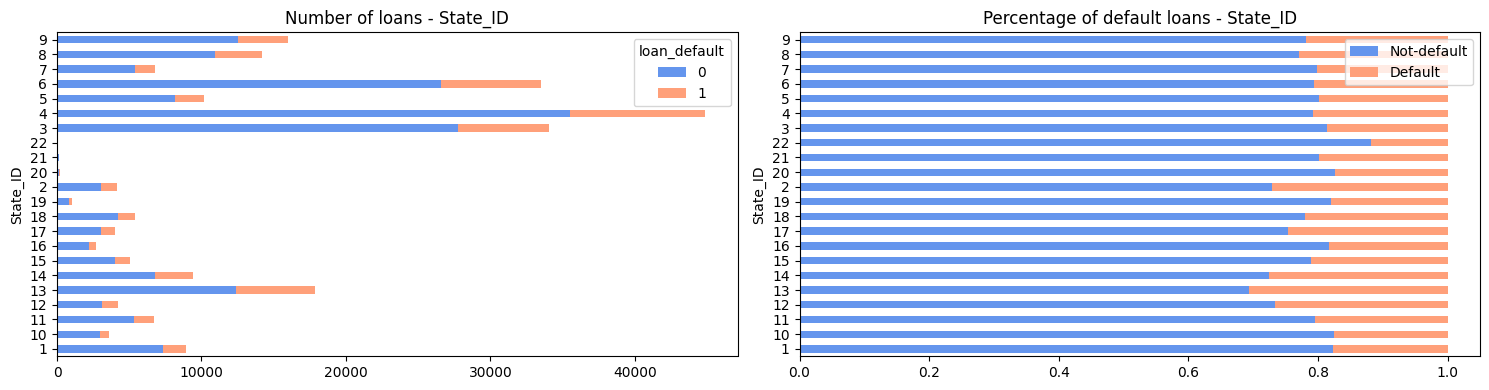

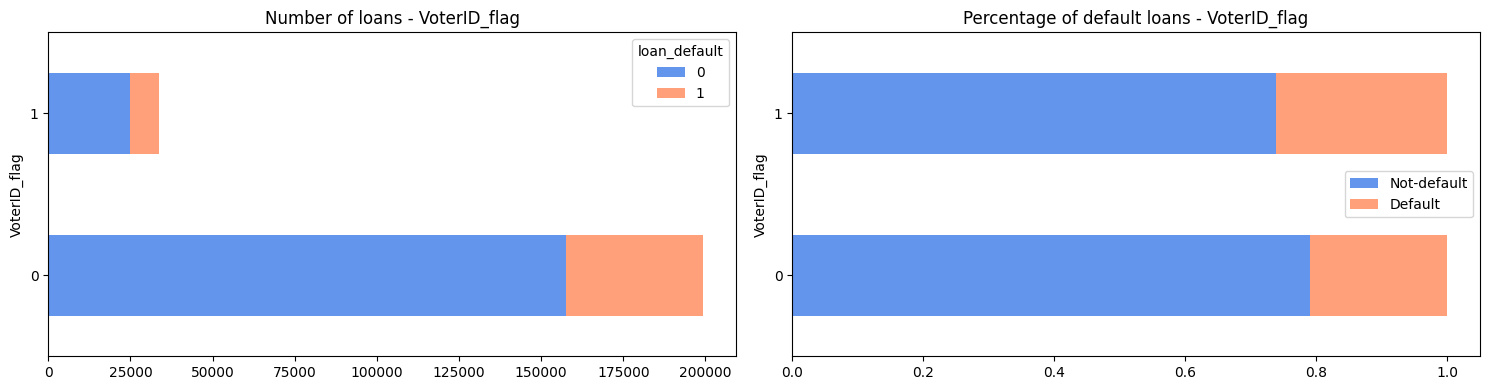

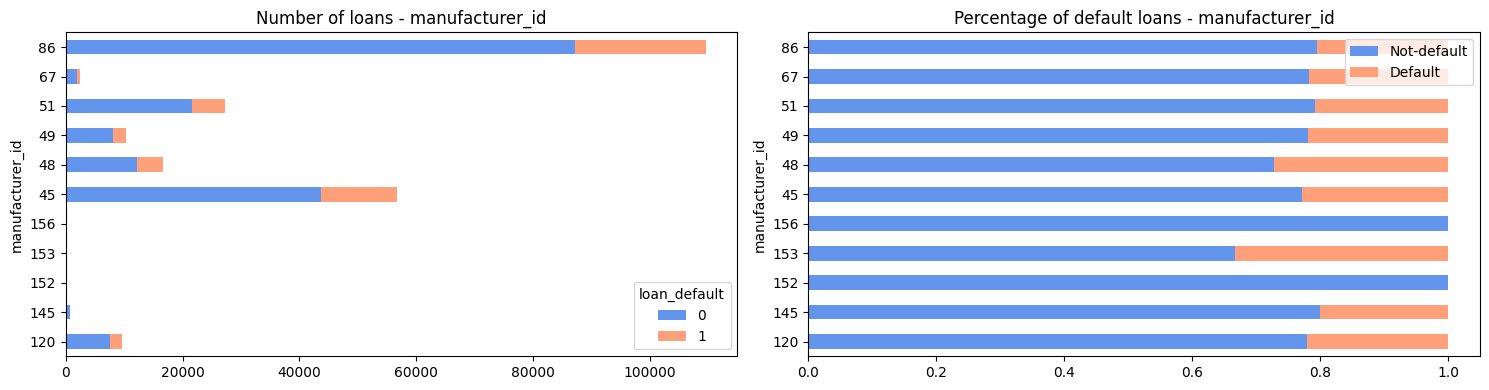

In [ ]:
# plot the categorical variables

for i, column in enumerate(cat_p_vars, 1):
    category_plot(df_loan_clean, column, targ_var)

Note:
- customers that did not share their Aadhar (identification ID) have shown relatively higher default percentage
- lower CNS_Score shows higher default rate
- manufacturer 153 with low number of loans, however, higher default percentage

## Modeling

### Train, Validation, Test Split

In [13]:
# further look at cleaned dataset
df_loan_clean.head()

,UniqueID,loan_default,disbursed_amount,asset_cost,ltv,manufacturer_id,Employment_Type,State_ID,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS_SCORE,PERFORM_CNS_SCORE_DESCRIPTION,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_AMOUNT,PRI_DISBURSED_AMOUNT,SEC_NO_OF_ACCTS,SEC_ACTIVE_ACCTS,SEC_OVERDUE_ACCTS,SEC_CURRENT_BALANCE,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,NO_OF_INQUIRIES,AgeInYear,DaysSinceDisbursement,AcctAgeInMonths,CreditHistLenInMonths
0,417428,0,55013,64080,88.17,86,Self employed,4,1,0,0,0,0,681.0,E-Low Risk,9.0,3.0,0.0,63727.0,100984.0,100984.0,0,0,0,0,0,0,5571.0,0,1,0,0,53.0,153.0,9,12
1,417429,0,72567,88919,83.78,86,Salaried,8,1,1,0,0,0,384.0,K-High Risk,3.0,1.0,1.0,103435.0,100000.0,100000.0,0,0,0,0,0,0,160963.0,0,0,1,0,39.0,153.0,36,42
2,417430,0,49049,64217,77.39,86,Self employed,6,1,0,0,0,0,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,NaN,0,0,0,0,36.0,153.0,0,0
3,417431,0,53503,76245,72.14,86,Self employed,3,1,0,0,0,0,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,NaN,0,0,0,0,32.0,153.0,0,0
4,417432,0,55559,65524,85.92,86,Self employed,6,1,0,0,0,0,721.0,D-Very Low Risk,8.0,7.0,0.0,1692406.0,2098401.0,2066815.0,0,0,0,0,0,0,15028.0,0,3,2,0,28.0,153.0,15,35


In [14]:
df_loan_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 36 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UniqueID                             233154 non-null  int64  
 1   loan_default                         233154 non-null  int64  
 2   disbursed_amount                     233154 non-null  int64  
 3   asset_cost                           233154 non-null  int64  
 4   ltv                                  233154 non-null  float64
 5   manufacturer_id                      233154 non-null  object 
 6   Employment_Type                      225493 non-null  object 
 7   State_ID                             233154 non-null  object 
 8   Aadhar_flag                          233154 non-null  object 
 9   PAN_flag                             233154 non-null  object 
 10  VoterID_flag                         233154 non-null  object 
 11  Driving_flag 

In [16]:
# # check binary variable
# df_loan_clean['Aadhar_flag'].value_counts()

# # convert binary categorical columns to int
# binary_cat_vars = ['Aadhar_flag','Driving_flag','PAN_flag','Passport_flag', 'VoterID_flag']
# df_loan_clean[binary_cat_vars] = df_loan_clean[binary_cat_vars].applymap(int)

# # check
# df_loan_clean['Aadhar_flag'].sum()

In [15]:
# split data into 80/20 while keeping the distribution of bad loans in test set same as that in the pre-split dataset

# drop ID and target columns for X
X = df_loan_clean.drop(columns=['UniqueID', 'loan_default'], axis = 1)
# set target variable column for y
y = df_loan_clean['loan_default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(186523, 34) (46631, 34) (186523,) (46631,)


In [18]:
# # Splitting data into train and validation set
# X_train, X_val, y_train, y_val = train_test_split(X_train,
#                                                   y_train,
#                                                   test_size=0.2,
#                                                   random_state=42,
#                                                   stratify=y_train)

# # Check
# print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


(149218, 34) (37305, 34) (149218,) (37305,)


In [19]:
# print(f"Default rate for train set: {np.round(y_train.mean()*100,2)}%, \
# \nDefault rate for val set: {np.round(y_val.mean()*100,2)}%, \
# \nDefault rate for test set: {np.round(y_test.mean()*100,2)}%")

Default rate for train set: 21.71%, 
Default rate for val set: 21.71%, 
Default rate for test set: 21.71%


### OneHotEncoding for categorical variables

In [16]:
# set column list for OHE

ohe_columns = list(X_train.select_dtypes('object').columns)

ohe_columns

['manufacturer_id',
 'Employment_Type',
 'State_ID',
 'Aadhar_flag',
 'PAN_flag',
 'VoterID_flag',
 'Driving_flag',
 'Passport_flag',
 'PERFORM_CNS_SCORE_DESCRIPTION']

In [17]:
# Create the column transformer with OneHotEncoding
ohe_coltf = ColumnTransformer(transformers = [('ohe',
                                OneHotEncoder(handle_unknown='infrequent_if_exist', drop='if_binary'),
                                ohe_columns)],
                              remainder = "passthrough")


# Fit
ohe_coltf.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='infrequent_if_exist'),
                                 ['manufacturer_id', 'Employment_Type',
                                  'State_ID', 'Aadhar_flag', 'PAN_flag',
                                  'VoterID_flag', 'Driving_flag',
                                  'Passport_flag',
                                  'PERFORM_CNS_SCORE_DESCRIPTION'])])

In [18]:
input_features = ohe_coltf.feature_names_in_
input_features

array(['disbursed_amount', 'asset_cost', 'ltv', 'manufacturer_id',
       'Employment_Type', 'State_ID', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag',
       'PERFORM_CNS_SCORE', 'PERFORM_CNS_SCORE_DESCRIPTION',
       'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS',
       'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT',
       'PRI_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS',
       'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE',
       'SEC_SANCTIONED_AMOUNT', 'SEC_DISBURSED_AMOUNT',
       'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT',
       'NEW_ACCTS_IN_LAST_SIX_MONTHS',
       'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'NO_OF_INQUIRIES',
       'AgeInYear', 'DaysSinceDisbursement', 'AcctAgeInMonths',
       'CreditHistLenInMonths'], dtype=object)

In [230]:
len(input_features)

34

In [19]:
# Feature names
trans_features = ohe_coltf.get_feature_names_out()
trans_features

array(['ohe__manufacturer_id_120', 'ohe__manufacturer_id_145',
       'ohe__manufacturer_id_152', 'ohe__manufacturer_id_153',
       'ohe__manufacturer_id_156', 'ohe__manufacturer_id_45',
       'ohe__manufacturer_id_48', 'ohe__manufacturer_id_49',
       'ohe__manufacturer_id_51', 'ohe__manufacturer_id_67',
       'ohe__manufacturer_id_86', 'ohe__Employment_Type_Salaried',
       'ohe__Employment_Type_Self employed', 'ohe__Employment_Type_nan',
       'ohe__State_ID_1', 'ohe__State_ID_10', 'ohe__State_ID_11',
       'ohe__State_ID_12', 'ohe__State_ID_13', 'ohe__State_ID_14',
       'ohe__State_ID_15', 'ohe__State_ID_16', 'ohe__State_ID_17',
       'ohe__State_ID_18', 'ohe__State_ID_19', 'ohe__State_ID_2',
       'ohe__State_ID_20', 'ohe__State_ID_21', 'ohe__State_ID_22',
       'ohe__State_ID_3', 'ohe__State_ID_4', 'ohe__State_ID_5',
       'ohe__State_ID_6', 'ohe__State_ID_7', 'ohe__State_ID_8',
       'ohe__State_ID_9', 'ohe__Aadhar_flag_1', 'ohe__PAN_flag_1',
       'ohe__VoterID_f

In [232]:
# train_features = [feature.split('__')[1] for feature in trans_features]
# train_features

In [20]:
# Apply the transformations
transformed = ohe_coltf.transform(X_train)

# Check
transformed

array([[  0.,   0.,   0., ...,  68.,   0.,   0.],
       [  0.,   0.,   0., ..., 130.,   0.,   0.],
       [  0.,   0.,   0., ...,  66.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,  63.,   5.,   8.],
       [  0.,   0.,   0., ...,  67.,   0.,   0.],
       [  0.,   0.,   0., ...,  64.,   0.,   0.]])

In [21]:
# Put in a DataFrame
X_train_transformed = pd.DataFrame(transformed,
                                   columns=ohe_coltf.get_feature_names_out())
X_train_transformed.head()

,ohe__manufacturer_id_120,ohe__manufacturer_id_145,ohe__manufacturer_id_152,ohe__manufacturer_id_153,ohe__manufacturer_id_156,ohe__manufacturer_id_45,ohe__manufacturer_id_48,ohe__manufacturer_id_49,ohe__manufacturer_id_51,ohe__manufacturer_id_67,ohe__manufacturer_id_86,ohe__Employment_Type_Salaried,ohe__Employment_Type_Self employed,ohe__Employment_Type_nan,ohe__State_ID_1,ohe__State_ID_10,ohe__State_ID_11,ohe__State_ID_12,ohe__State_ID_13,ohe__State_ID_14,ohe__State_ID_15,ohe__State_ID_16,ohe__State_ID_17,ohe__State_ID_18,ohe__State_ID_19,ohe__State_ID_2,ohe__State_ID_20,ohe__State_ID_21,ohe__State_ID_22,ohe__State_ID_3,ohe__State_ID_4,ohe__State_ID_5,ohe__State_ID_6,ohe__State_ID_7,ohe__State_ID_8,ohe__State_ID_9,ohe__Aadhar_flag_1,ohe__PAN_flag_1,ohe__VoterID_flag_1,ohe__Driving_flag_1,ohe__Passport_flag_1,ohe__PERFORM_CNS_SCORE_DESCRIPTION_,ohe__PERFORM_CNS_SCORE_DESCRIPTION_A-Very Low Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_B-Very Low Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_C-Very Low Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_D-Very Low Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_E-Low Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_F-Low Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_G-Low Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_H-Medium Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_I-Medium Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_J-High Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_K-High Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_L-Very High Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_M-Very High Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: More than 50 active Accounts found,ohe__PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: No Activity seen on the customer (Inactive),ohe__PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: No Updates available in last 36 months,ohe__PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: Not Enough Info available on the customer,ohe__PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: Only a Guarantor,ohe__PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: Sufficient History Not Available,remainder__disbursed_amount,remainder__asset_cost,remainder__ltv,remainder__PERFORM_CNS_SCORE,remainder__PRI_NO_OF_ACCTS,remainder__PRI_ACTIVE_ACCTS,remainder__PRI_OVERDUE_ACCTS,remainder__PRI_CURRENT_BALANCE,remainder__PRI_SANCTIONED_AMOUNT,remainder__PRI_DISBURSED_AMOUNT,remainder__SEC_NO_OF_ACCTS,remainder__SEC_ACTIVE_ACCTS,remainder__SEC_OVERDUE_ACCTS,remainder__SEC_CURRENT_BALANCE,remainder__SEC_SANCTIONED_AMOUNT,remainder__SEC_DISBURSED_AMOUNT,remainder__PRIMARY_INSTAL_AMT,remainder__SEC_INSTAL_AMT,remainder__NEW_ACCTS_IN_LAST_SIX_MONTHS,remainder__DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,remainder__NO_OF_INQUIRIES,remainder__AgeInYear,remainder__DaysSinceDisbursement,remainder__AcctAgeInMonths,remainder__CreditHistLenInMonths
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48349.0,67013.0,74.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,29.0,68.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57813.0,65913.0,89.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,26.0,130.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45308.0,59400.0,79.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,5.0,44.0,66.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.

In [209]:
# # Apply the transformations on validation set
# transformed_val = ohe_coltf.transform(X_val)

# # Check
# transformed_val

# # Put in a DataFrame
# X_val_transformed = pd.DataFrame(transformed_val,
#                                 columns=ohe_coltf.get_feature_names_out())
# X_val_transformed.head()

array([[  0.,   0.,   0., ...,  97.,   0.,   0.],
       [  0.,   0.,   0., ...,  95.,  18.,  40.],
       [  0.,   0.,   0., ..., 109.,  14.,  25.],
       ...,
       [  0.,   0.,   0., ...,  62.,   0.,   0.],
       [  0.,   0.,   0., ..., 123.,  26.,  63.],
       [  0.,   0.,   0., ..., 150.,  45.,  64.]])

In [22]:
# Apply the transformations on test set
transformed_test = ohe_coltf.transform(X_test)

# Check
transformed_test

# Put in a DataFrame
X_test_transformed = pd.DataFrame(transformed_test,
                                columns=ohe_coltf.get_feature_names_out())
X_test_transformed.head()

,ohe__manufacturer_id_120,ohe__manufacturer_id_145,ohe__manufacturer_id_152,ohe__manufacturer_id_153,ohe__manufacturer_id_156,ohe__manufacturer_id_45,ohe__manufacturer_id_48,ohe__manufacturer_id_49,ohe__manufacturer_id_51,ohe__manufacturer_id_67,ohe__manufacturer_id_86,ohe__Employment_Type_Salaried,ohe__Employment_Type_Self employed,ohe__Employment_Type_nan,ohe__State_ID_1,ohe__State_ID_10,ohe__State_ID_11,ohe__State_ID_12,ohe__State_ID_13,ohe__State_ID_14,ohe__State_ID_15,ohe__State_ID_16,ohe__State_ID_17,ohe__State_ID_18,ohe__State_ID_19,ohe__State_ID_2,ohe__State_ID_20,ohe__State_ID_21,ohe__State_ID_22,ohe__State_ID_3,ohe__State_ID_4,ohe__State_ID_5,ohe__State_ID_6,ohe__State_ID_7,ohe__State_ID_8,ohe__State_ID_9,ohe__Aadhar_flag_1,ohe__PAN_flag_1,ohe__VoterID_flag_1,ohe__Driving_flag_1,ohe__Passport_flag_1,ohe__PERFORM_CNS_SCORE_DESCRIPTION_,ohe__PERFORM_CNS_SCORE_DESCRIPTION_A-Very Low Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_B-Very Low Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_C-Very Low Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_D-Very Low Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_E-Low Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_F-Low Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_G-Low Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_H-Medium Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_I-Medium Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_J-High Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_K-High Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_L-Very High Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_M-Very High Risk,ohe__PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: More than 50 active Accounts found,ohe__PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: No Activity seen on the customer (Inactive),ohe__PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: No Updates available in last 36 months,ohe__PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: Not Enough Info available on the customer,ohe__PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: Only a Guarantor,ohe__PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: Sufficient History Not Available,remainder__disbursed_amount,remainder__asset_cost,remainder__ltv,remainder__PERFORM_CNS_SCORE,remainder__PRI_NO_OF_ACCTS,remainder__PRI_ACTIVE_ACCTS,remainder__PRI_OVERDUE_ACCTS,remainder__PRI_CURRENT_BALANCE,remainder__PRI_SANCTIONED_AMOUNT,remainder__PRI_DISBURSED_AMOUNT,remainder__SEC_NO_OF_ACCTS,remainder__SEC_ACTIVE_ACCTS,remainder__SEC_OVERDUE_ACCTS,remainder__SEC_CURRENT_BALANCE,remainder__SEC_SANCTIONED_AMOUNT,remainder__SEC_DISBURSED_AMOUNT,remainder__PRIMARY_INSTAL_AMT,remainder__SEC_INSTAL_AMT,remainder__NEW_ACCTS_IN_LAST_SIX_MONTHS,remainder__DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,remainder__NO_OF_INQUIRIES,remainder__AgeInYear,remainder__DaysSinceDisbursement,remainder__AcctAgeInMonths,remainder__CreditHistLenInMonths
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32341.0,68150.0,49.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,28.0,125.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52478.0,68930.0,79.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,25.0,77.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51318.0,68289.0,77.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,45.0,67.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

### Create feature interaction constraints group

In [23]:
# set interaction constraints for training

var_groups = []

for i in range(len(ohe_columns)):
  vars = []
  for j in trans_features:
    if ohe_columns[i] in j:
      # j=j.split('__')[1]
      vars.append(j)

  var_groups.append(vars)


In [24]:
var_groups

[['ohe__manufacturer_id_120',
  'ohe__manufacturer_id_145',
  'ohe__manufacturer_id_152',
  'ohe__manufacturer_id_153',
  'ohe__manufacturer_id_156',
  'ohe__manufacturer_id_45',
  'ohe__manufacturer_id_48',
  'ohe__manufacturer_id_49',
  'ohe__manufacturer_id_51',
  'ohe__manufacturer_id_67',
  'ohe__manufacturer_id_86'],
 ['ohe__Employment_Type_Salaried',
  'ohe__Employment_Type_Self employed',
  'ohe__Employment_Type_nan'],
 ['ohe__State_ID_1',
  'ohe__State_ID_10',
  'ohe__State_ID_11',
  'ohe__State_ID_12',
  'ohe__State_ID_13',
  'ohe__State_ID_14',
  'ohe__State_ID_15',
  'ohe__State_ID_16',
  'ohe__State_ID_17',
  'ohe__State_ID_18',
  'ohe__State_ID_19',
  'ohe__State_ID_2',
  'ohe__State_ID_20',
  'ohe__State_ID_21',
  'ohe__State_ID_22',
  'ohe__State_ID_3',
  'ohe__State_ID_4',
  'ohe__State_ID_5',
  'ohe__State_ID_6',
  'ohe__State_ID_7',
  'ohe__State_ID_8',
  'ohe__State_ID_9'],
 ['ohe__Aadhar_flag_1'],
 ['ohe__PAN_flag_1'],
 ['ohe__VoterID_flag_1'],
 ['ohe__Driving_flag

In [25]:
# generate remainder variables from columntransformer features

remainder = [remainder for remainder in trans_features if('remainder' in remainder)]
remainder = [remainder[i:i+1] for i in range(0, len(remainder), 1)]

In [26]:
remainder

[['remainder__disbursed_amount'],
 ['remainder__asset_cost'],
 ['remainder__ltv'],
 ['remainder__PERFORM_CNS_SCORE'],
 ['remainder__PRI_NO_OF_ACCTS'],
 ['remainder__PRI_ACTIVE_ACCTS'],
 ['remainder__PRI_OVERDUE_ACCTS'],
 ['remainder__PRI_CURRENT_BALANCE'],
 ['remainder__PRI_SANCTIONED_AMOUNT'],
 ['remainder__PRI_DISBURSED_AMOUNT'],
 ['remainder__SEC_NO_OF_ACCTS'],
 ['remainder__SEC_ACTIVE_ACCTS'],
 ['remainder__SEC_OVERDUE_ACCTS'],
 ['remainder__SEC_CURRENT_BALANCE'],
 ['remainder__SEC_SANCTIONED_AMOUNT'],
 ['remainder__SEC_DISBURSED_AMOUNT'],
 ['remainder__PRIMARY_INSTAL_AMT'],
 ['remainder__SEC_INSTAL_AMT'],
 ['remainder__NEW_ACCTS_IN_LAST_SIX_MONTHS'],
 ['remainder__DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS'],
 ['remainder__NO_OF_INQUIRIES'],
 ['remainder__AgeInYear'],
 ['remainder__DaysSinceDisbursement'],
 ['remainder__AcctAgeInMonths'],
 ['remainder__CreditHistLenInMonths']]

In [27]:
# combine the variable groups and remainder variables
for i in range(len(remainder)):
  var_groups.append(remainder[i])

var_groups

[['ohe__manufacturer_id_120',
  'ohe__manufacturer_id_145',
  'ohe__manufacturer_id_152',
  'ohe__manufacturer_id_153',
  'ohe__manufacturer_id_156',
  'ohe__manufacturer_id_45',
  'ohe__manufacturer_id_48',
  'ohe__manufacturer_id_49',
  'ohe__manufacturer_id_51',
  'ohe__manufacturer_id_67',
  'ohe__manufacturer_id_86'],
 ['ohe__Employment_Type_Salaried',
  'ohe__Employment_Type_Self employed',
  'ohe__Employment_Type_nan'],
 ['ohe__State_ID_1',
  'ohe__State_ID_10',
  'ohe__State_ID_11',
  'ohe__State_ID_12',
  'ohe__State_ID_13',
  'ohe__State_ID_14',
  'ohe__State_ID_15',
  'ohe__State_ID_16',
  'ohe__State_ID_17',
  'ohe__State_ID_18',
  'ohe__State_ID_19',
  'ohe__State_ID_2',
  'ohe__State_ID_20',
  'ohe__State_ID_21',
  'ohe__State_ID_22',
  'ohe__State_ID_3',
  'ohe__State_ID_4',
  'ohe__State_ID_5',
  'ohe__State_ID_6',
  'ohe__State_ID_7',
  'ohe__State_ID_8',
  'ohe__State_ID_9'],
 ['ohe__Aadhar_flag_1'],
 ['ohe__PAN_flag_1'],
 ['ohe__VoterID_flag_1'],
 ['ohe__Driving_flag

In [28]:
len(var_groups)

34

### Setup training pipleine

In [29]:
# Initialize and run XGBoostClassifier


start = time.time()
val_metrics = ['auc', 'logloss']

estimators_xgb = [
    # ('transformer', ohe_coltf),
                  ('model', XGBClassifier(max_depth=3,
                                               gamma=1,
                                               min_child_weight=100,
                                              #  max_leaves= 256,
                                               n_estimators=50,
                                               learning_rate=0.5,
                                               nthread=24,
                                                objective='binary:logistic',
                                               reg_alpha=0,
                                               reg_lambda=0,
                                               interaction_constraints=var_groups,
                                               eval_metric=val_metrics,
                                                tree_method='hist',
                                              #  colsample_bytree=0.7,
                                              #  subsample=0.8,
                                              #  verbosity=1,
                                               random_state=42
                                               ))]

pipe_xgb = Pipeline(estimators_xgb)

pipe_xgb.fit(X_train_transformed, y_train)

stop = time.time()
runtime = stop-start
print(f"Runtime: {round(runtime,2)} seconds")

Runtime: 4.42 seconds


In [30]:
result_xgb = model_auc_score(pipe_xgb, X_test_transformed, y_test)
result_xgb[0]

0.6515739577580807

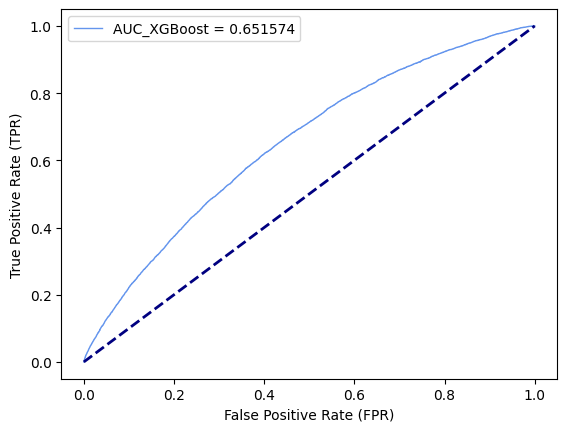

In [31]:
model_auc_plot(result_xgb, 'XGBoost')

### Understand feature importance for scorecard building

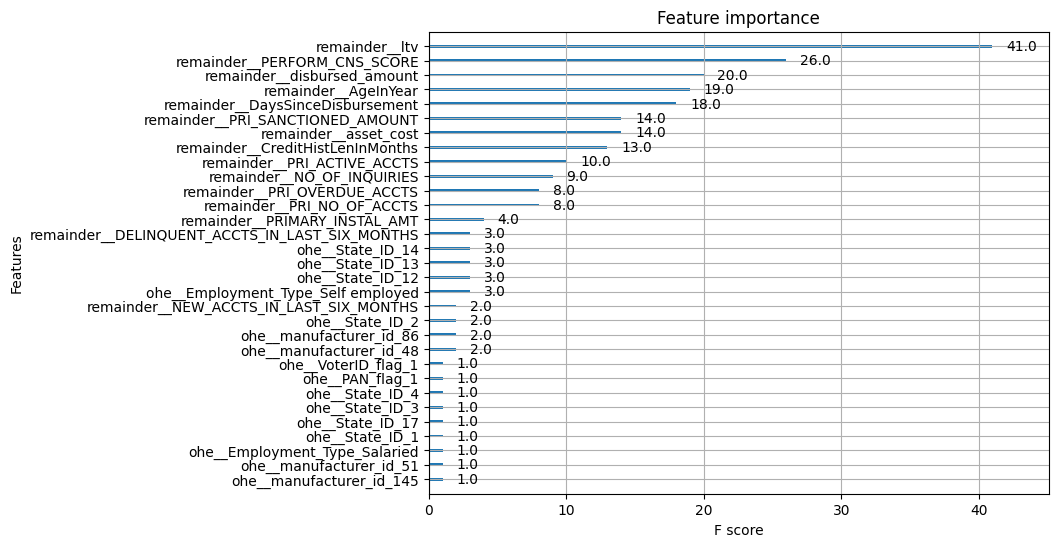

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
plot_importance(pipe_xgb.named_steps.model, ax=ax)
plt.show()


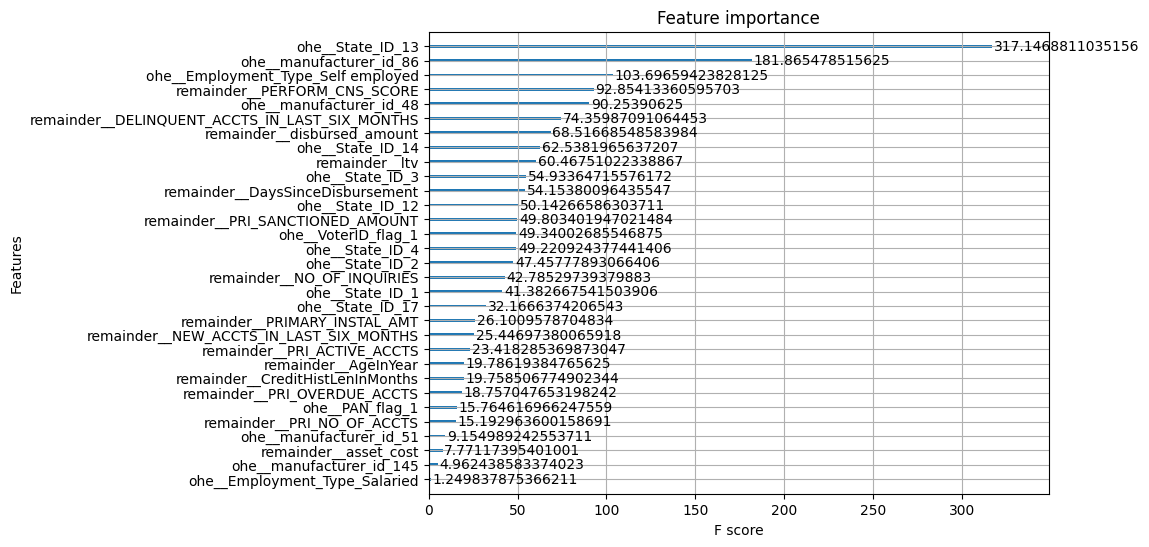

In [33]:
# look at feature importance by 'gain'

fig, ax = plt.subplots(figsize=(8,6))
plot_importance(pipe_xgb.named_steps.model, importance_type='gain', ax=ax)
plt.show()

In [34]:
xgb_model = pipe_xgb.named_steps.model
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['auc', 'logloss'],
              feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
              importance_type=None,
              interaction_constraints=[['ohe__manufacturer_id_120',
                                        'ohe__manufac...
                                       ['remainder__DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS'],
                                       ['remainder__NO_OF_INQUIRIES'], ...],
              learning_rate=0.5, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=100, missing=nan,
              monotone_constraints=None, n_estimators=50, n_jobs=None,
              nthread=24, num_parallel_tree=None, predictor=None, ...)

In [35]:
xgb_booster = pipe_xgb.named_steps.model.get_booster()
xgb_booster

In [36]:
treemodel_df = xgb_booster.trees_to_dataframe()
treemodel_df

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,remainder__disbursed_amount,50803.0,0-1,0-2,0-2,994.476562,46630.750000,NaN
1,0,1,0-1,remainder__disbursed_amount,44409.0,0-3,0-4,0-4,93.435547,17552.000000,NaN
2,0,2,0-2,remainder__disbursed_amount,53378.0,0-5,0-6,0-6,85.173828,29078.750000,NaN
3,0,3,0-3,remainder__disbursed_amount,32884.0,0-7,0-8,0-8,6.347656,8552.000000,NaN
4,0,4,0-4,remainder__disbursed_amount,47645.0,0-9,0-10,0-10,8.683594,9000.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
517,49,2,49-2,remainder__PRI_ACTIVE_ACCTS,9.0,49-5,49-6,49-6,1.698602,552.093567,NaN
518,49,3,49-3,Leaf,NaN,NaN,NaN,NaN,0.002225,28239.775400,NaN
519,49,4,49-4,Leaf,NaN,NaN,NaN,NaN,-0.014150,1651.929810,NaN
520,49,5,49-5,Leaf,NaN,NaN,NaN,NaN,-0.049149,305.396637,NaN


In [39]:
treemodel_df.groupby(['Tree']).first()

,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
Tree,,,,,,,,,,
0,0,0-0,remainder__disbursed_amount,50803.000000,0-1,0-2,0-2,994.476562,46630.7500,NaN
1,0,1-0,remainder__PERFORM_CNS_SCORE,645.000000,1-1,1-2,1-1,948.941406,43035.6719,NaN
2,0,2-0,remainder__ltv,72.970001,2-1,2-2,2-2,852.285645,38571.6836,NaN
3,0,3-0,ohe__State_ID_13,1.000000,3-1,3-2,3-2,730.107422,35445.7031,NaN
4,0,4-0,remainder__PERFORM_CNS_SCORE,659.000000,4-1,4-2,4-1,498.009918,33614.6641,NaN
5,0,5-0,remainder__ltv,74.120003,5-1,5-2,5-2,493.321259,32526.3887,NaN
6,0,6-0,remainder__PRI_SANCTIONED_AMOUNT,209000.000000,6-1,6-2,6-1,452.913635,31901.8945,NaN
7,0,7-0,remainder__DaysSinceDisbursement,71.000000,7-1,7-2,7-2,392.388794,31610.2285,NaN
8,0,8-0,ohe__manufacturer_id_86,1.000000,8-1,8-2,8-2,274.327271,31441.6719,NaN


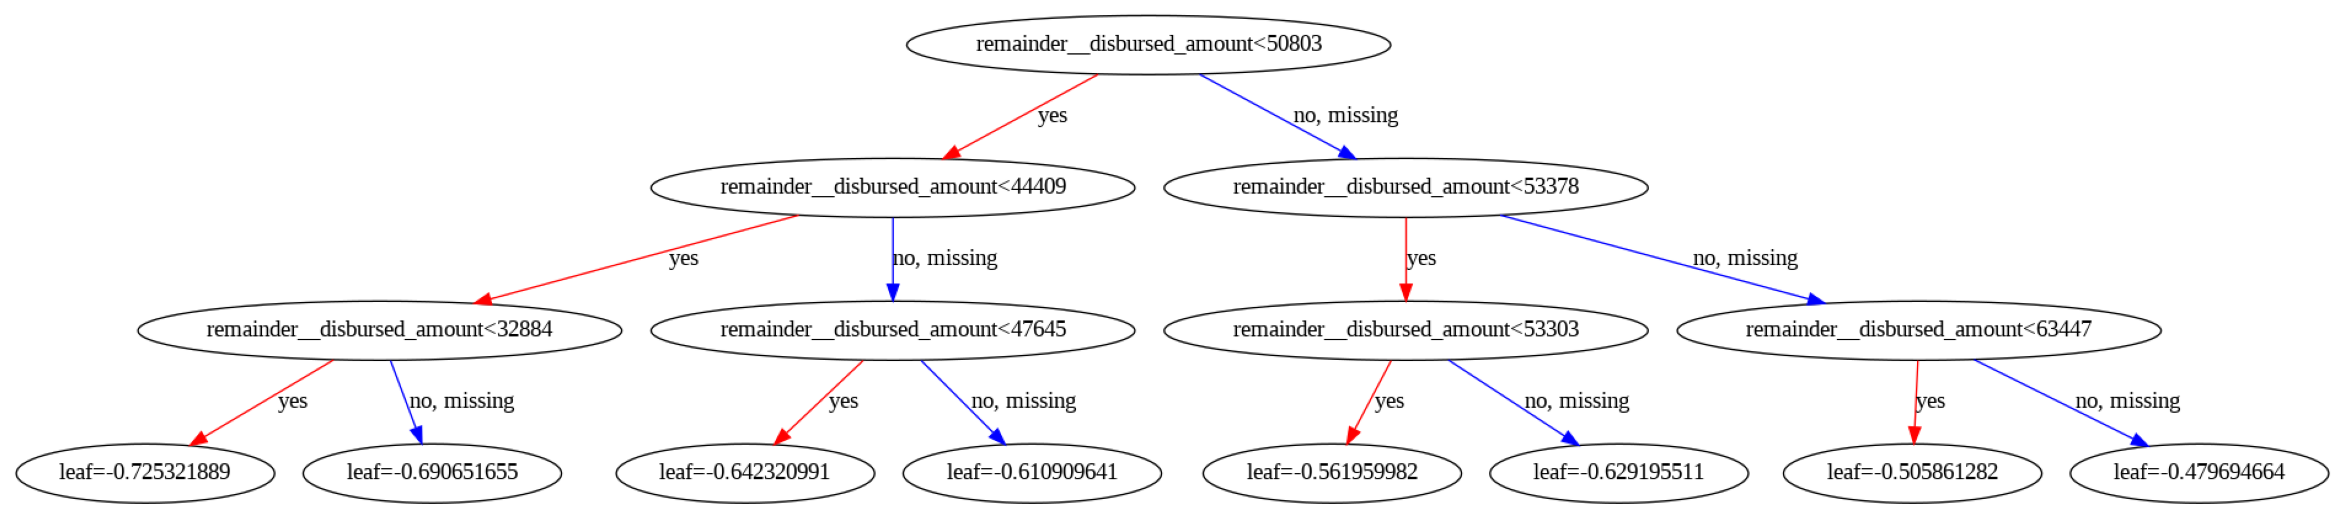

In [41]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(xgb_model, num_trees=0, ax=ax)
plt.show()

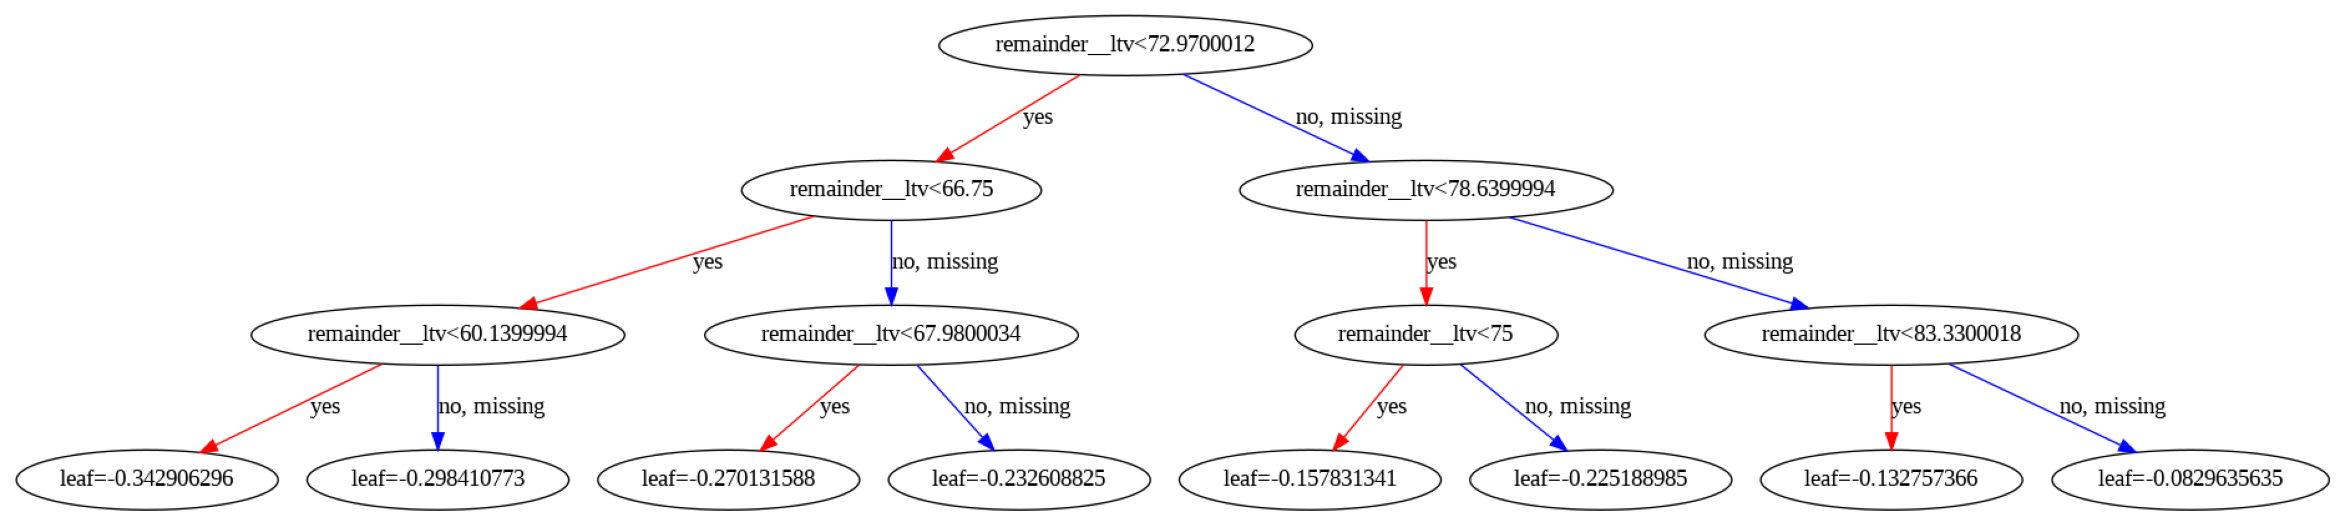

In [43]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(xgb_model, num_trees=2, ax=ax)
plt.show()

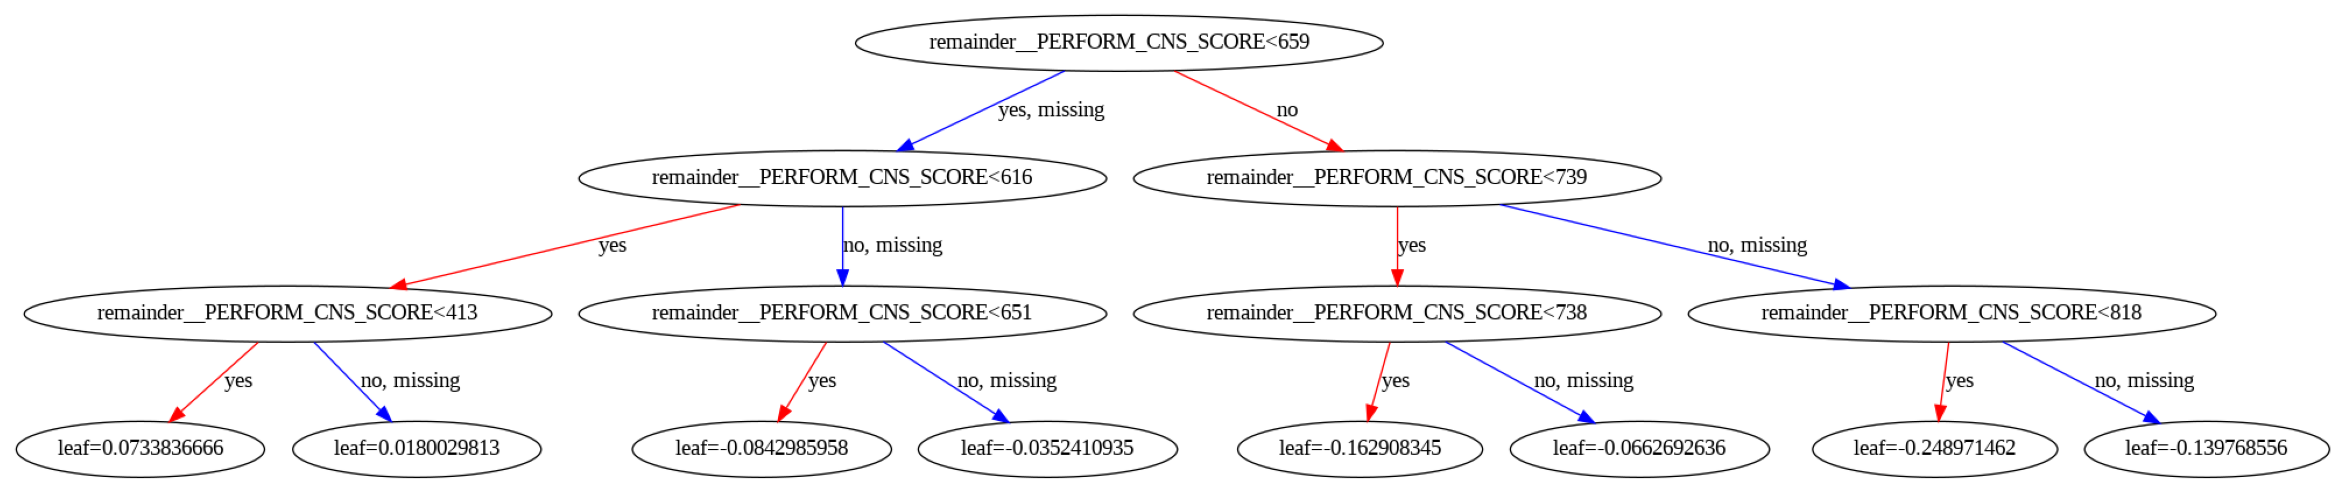

In [44]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(xgb_model, num_trees=4, ax=ax)
plt.show()